In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# Data cleaning of biodiversity data set

**Scenario**:<br> You are interested occurrence data for a number of species in Flanders. Unfortunately , the sources for this type of data are still scattered among different institutes. After a mailing campaign, you receive a number of files from different formats, in various data formats and styles... 

You decide to be brave and script the interpretation and transformation, in order to provide reproducibility of your work. Moreover, similar analysis will be needed in the future with new data requests. You *hope* that future data requests will result in similar data formats from the individual partners. So, having a scripts will enhance the efficiency at that moment.

Besides from the technical differences in the data formats (`csv`, `excel`, `shapefile`, `sqlite`...), there are also differences in the naming of the concent. For example, the cordinates, can be named `x`/`y`, `decimalLatitude`/`decimalLongitude`, `lat`/`long`... Luckely, you know of an international **open data standard** to describe occurrence data, i.e. [Darwin Core (DwC)](LINK TO TDWG). Instead of inventing your own data model, you decide to comply to this international standard. The latter will enhance communication and will also make your data compliant to other data services working with this kind of data.

In short, the DwC describes a flat table (cfr. CSV) with an agreed name convention on the header names and conventions on how certain data types need to be represented. Whereas the standard definitions are out of scope here, an in depth description is given [here](LINK NR TERMS VAN DWC).

##  surveys.csv and species.csv

For this dataset, the data is provided in two different data files:
* `surveys.csv` the data with the surveys observed in the individual plots
* `species.csv` the overview list of the species shortnames

In [2]:
survey_data = pd.read_csv("../data/surveys.csv")

In [3]:
survey_data.head()

,record_id,month,day,year,plot,species,sex,wgt
0,1,7,16,1977,2,NaN,M,NaN
1,2,7,16,1977,3,NaN,M,NaN
2,3,7,16,1977,2,DM,F,NaN
3,4,7,16,1977,7,DM,M,NaN
4,5,7,16,1977,3,DM,M,NaN


In [4]:
len(survey_data)

35549

In [5]:
survey_data["species"].unique()

array([nan, 'DM', 'PF', 'PE', 'DS', 'PP', 'SH', 'OT', 'DO', 'OX', 'SS',
       'OL', 'RM', 'SA', 'PM', 'AH', 'DX', 'AB', 'CB', 'CM', 'CQ', 'RF',
       'PC', 'PG', 'PH', 'PU', 'CV', 'UR', 'UP', 'ZL', 'UL', 'CS', 'SC',
       'BA', 'SF', 'RO', 'AS', 'SO', 'PI', 'ST', 'CU', 'SU', 'RX', 'PB',
       'PL', 'PX', 'CT', 'US'], dtype=object)

In [6]:
species_data = pd.read_csv("../data/species.csv")

In [7]:
species_data.head()

,species_id,genus,species,taxa
0,AB,Amphispiza,bilineata,Bird
1,AH,Ammospermophilus,harrisi,Rodent-not censused
2,AS,Ammodramus,savannarum,Bird
3,BA,Baiomys,taylori,Rodent
4,CB,Campylorhynchus,brunneicapillus,Bird


In [8]:
species_data["species_id"].unique()

array(['AB', 'AH', 'AS', 'BA', 'CB', 'CM', 'CQ', 'CS', 'CT', 'CU', 'CV',
       'DM', 'DO', 'DS', 'DX', 'EO', 'GS', nan, 'NX', 'OL', 'OT', 'OX',
       'PB', 'PC', 'PE', 'PF', 'PG', 'PH', 'PI', 'PL', 'PM', 'PP', 'PU',
       'PX', 'RF', 'RM', 'RO', 'RX', 'SA', 'SB', 'SC', 'SF', 'SH', 'SO',
       'SS', 'ST', 'SU', 'SX', 'UL', 'UP', 'UR', 'US', 'XX', 'ZL', 'ZM'], dtype=object)

Apparently, there is also a `Nan` element in de species description:

In [9]:
species_data[species_data["species_id"].isnull()]

,species_id,genus,species,taxa
17,NaN,Neotoma,albigula,Rodent


However, it is rather remarkable that all the data that were annotated as `Nan` during the survey itself will be effectively `albigula`. So, we should properly handle the presence of `Nan` values:
* do not remove the records
* do not assign a name to the `Nan` values of the survey, but keep these records also Nan, as maybe we could find affirmation that surveys `Nan` values are effectively `albigula`. 

As we should be in contact with the data provider (are we are the provider ourself - just have to check thoe notes...- ), we expect to find an answer to this question rather soon. We decide to do the following: 
* Provide `albigula` with a new unique(!) ID in the `species` overview. as the other shortnames are picked on genus level, make the link to this one
* Keep the `Nan` values in the `survey` overview. If these are really `Nan` (basically anything), we just keep them as a reference. If it would all be `albigula`, we will map them to our ne keyword.

Check if our new keynam already exists in the species overview:

In [10]:
'NE' in species_data["species_id"]

False

Update the key of `albigula` to `NE`:

In [11]:
species_data[species_data["genus"] == "Neotoma"]

,species_id,genus,species,taxa
17,NaN,Neotoma,albigula,Rodent
18,NX,Neotoma,sp.,Rodent


In [12]:
species_data.loc[species_data["species"] == "albigula", "species_id"] = "NE"

In [13]:
species_data[species_data["genus"] == "Neotoma"]

,species_id,genus,species,taxa
17,NE,Neotoma,albigula,Rodent
18,NX,Neotoma,sp.,Rodent


### Merging data sets on key

As we now prepared the two series, we can combine the data. Making the combination of two data sets based on a common identifier is completely similar to the usage of `JOIN` operations in databases. In Pandas, this functionality is [`pd.merge`](LINK TOEVOEGEN):

We want to add the data of the species to the survey data, in order to see the full species names:

In [14]:
survey_data_enriched = pd.merge(survey_data, species_data, how="left",  # LEFT OR INNER?
                                left_on="species", right_on="species_id",
                                sort=True)

In [15]:
len(survey_data_enriched)

35549

The join is ok, but we are left with some redundant columns and strange naming:

In [16]:
survey_data_enriched = survey_data_enriched.drop(["species_x", "species_id"], axis=1)

In [17]:
survey_data_enriched.head()

,record_id,month,day,year,plot,sex,wgt,genus,species_y,taxa
0,3126,7,21,1980,8,NaN,NaN,Amphispiza,bilineata,Bird
1,3146,7,21,1980,24,NaN,NaN,Amphispiza,bilineata,Bird
2,3152,7,21,1980,19,NaN,NaN,Amphispiza,bilineata,Bird
3,3153,7,21,1980,22,NaN,NaN,Amphispiza,bilineata,Bird
4,3586,12,15,1980,16,NaN,NaN,Amphispiza,bilineata,Bird


In [18]:
survey_data_enriched = survey_data_enriched.rename(columns={"species_y": "species"})

In [19]:
survey_data_enriched.head()

,record_id,month,day,year,plot,sex,wgt,genus,species,taxa
0,3126,7,21,1980,8,NaN,NaN,Amphispiza,bilineata,Bird
1,3146,7,21,1980,24,NaN,NaN,Amphispiza,bilineata,Bird
2,3152,7,21,1980,19,NaN,NaN,Amphispiza,bilineata,Bird
3,3153,7,21,1980,22,NaN,NaN,Amphispiza,bilineata,Bird
4,3586,12,15,1980,16,NaN,NaN,Amphispiza,bilineata,Bird


### Create a eventDate-column

In the survey-dataset we received, the `month`, `day`, and `year` columns are containing the information about the date, i.e. `eventDate` in DarwinCore terms. We want this data in a ISO format `YYYY-MM-DD`. A convenvient Pandas function is the usage of `to_datatime`, which provides multiple options to interpret dates. One of thes options is th automatic interpretation of some `typical` words, like `year`, `month` and `day`.

In [20]:
pd.to_datetime(survey_data_enriched[["year", "month", "day"]])

ValueError: cannot assemble the datetimes: day is out of range for month

This is not workin as not all dates can be interpreted... We should get some more information on the reason of the errors. BY using the option `coerce`, the problem makers will be labeled as `NaT`:

In [22]:
sum(pd.to_datetime(survey_data_enriched[["year", "month", "day"]], 'coerce').isnull())

136

In [23]:
trouble_makers = survey_data_enriched[pd.to_datetime(survey_data_enriched[["year", "month", "day"]], 'coerce').isnull()]

In [24]:
trouble_makers.head()

,record_id,month,day,year,plot,sex,wgt,genus,species,taxa
687,31489,9,31,2000,14,NaN,NaN,Ammospermophilus,harrisi,Rodent-not censused
10690,30662,4,31,2000,9,F,52.0,Dipodomys,merriami,Rodent
10691,30665,4,31,2000,9,F,44.0,Dipodomys,merriami,Rodent
10692,30666,4,31,2000,9,M,50.0,Dipodomys,merriami,Rodent
10693,30667,4,31,2000,9,F,39.0,Dipodomys,merriami,Rodent


In [25]:
trouble_makers['day'].unique()

array([31])

In [26]:
trouble_makers['month'].unique()

array([9, 4])

In [27]:
trouble_makers['year'].unique()

array([2000])

So, basically the problem is the presence of day `31` during the months April and September of the year 2000. At this moment, we would have to recheck the original data in order to know how issue could be solved. Apparently, there has been a data-entry problem in 2000, making the `31` days during this period should be `30`. It would be optimal to correct this in the source dataset, but for the further exercise, it will be corrected here:

In [28]:
survey_data_enriched.loc[pd.to_datetime(survey_data_enriched[["year", "month", "day"]], 'coerce').isnull(), "day"] = 30

Now, we do the parsing again to create a proper `eventDate` field, containing the dates:

In [29]:
survey_data_enriched["eventDate"] = pd.to_datetime(survey_data_enriched[["year", "month", "day"]])

Just let's do a check the amount of data for each year:

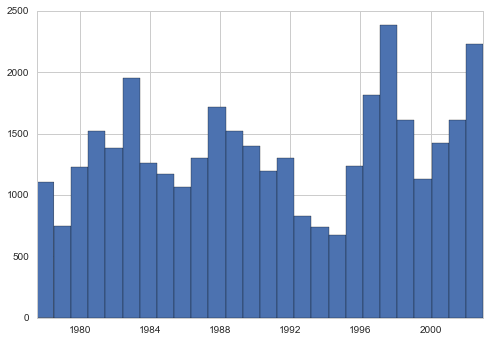

In [30]:
survey_data_enriched["eventDate"].hist(bins=len(survey_data_enriched["year"].unique()))

However, this type of intensity in activity would be more interestin in a heatmap. Let's reformat this data to plot is as a heatmap:

In [31]:
heatmap_prep = survey_data_enriched.groupby(["year", "month"]).count()["record_id"].reset_index()
heatmap_prep = heatmap_prep.pivot(index="year", columns="month", values="record_id")

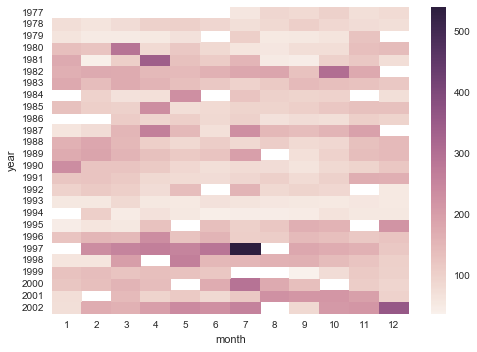

In [32]:
fig, ax = plt.subplots()
ax = sns.heatmap(heatmap_prep)

We can easily reuse this idea to check the record counts of the days versus months:

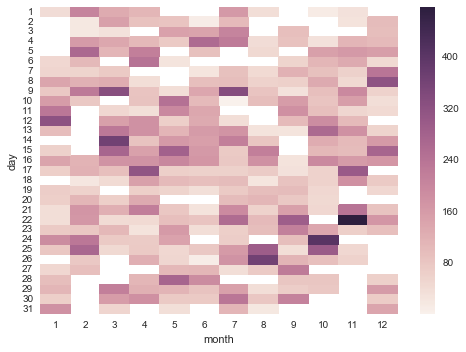

In [33]:
heatmap_prep = survey_data_enriched.groupby(["day", "month"]).count()["record_id"].reset_index()
heatmap_prep = heatmap_prep.pivot(index="day", columns="month", values="record_id")
fig, ax = plt.subplots()
ax = sns.heatmap(heatmap_prep)

In [36]:
survey_data_enriched.head()

,record_id,month,day,year,plot,sex,wgt,genus,species,taxa,eventDate
0,3126,7,21,1980,8,NaN,NaN,Amphispiza,bilineata,Bird,1980-07-21
1,3146,7,21,1980,24,NaN,NaN,Amphispiza,bilineata,Bird,1980-07-21
2,3152,7,21,1980,19,NaN,NaN,Amphispiza,bilineata,Bird,1980-07-21
3,3153,7,21,1980,22,NaN,NaN,Amphispiza,bilineata,Bird,1980-07-21
4,3586,12,15,1980,16,NaN,NaN,Amphispiza,bilineata,Bird,1980-12-15


In [41]:
survey_data_enriched['taxa'].unique()

array(['Bird', 'Rodent-not censused', 'Rodent', 'Reptile', 'Rabbit', nan], dtype=object)

In [37]:
survey_data_enriched['sex'].unique()

array([nan, 'R', 'M', 'F', 'P', 'Z'], dtype=object)

In [39]:
survey_data_enriched['wgt'].unique()

array([  nan,    7.,    6.,    8.,    9.,   10.,   18.,   12.,   11.,
         13.,   40.,   48.,   29.,   46.,   36.,   35.,   22.,   42.,
         41.,   37.,   43.,   45.,   39.,   30.,   34.,   31.,   44.,
         33.,   51.,   53.,   49.,   50.,   47.,   55.,   38.,   23.,
         25.,   52.,   56.,   26.,   21.,   16.,   19.,   24.,   28.,
         17.,   32.,   27.,   54.,   65.,   20.,   57.,   61.,   58.,
         59.,   62.,   60.,   63.,   15.,   66.,   14.,   64.,   70.,
         73.,   67.,   68.,   69.,   76.,  117.,  121.,  115.,  120.,
        118.,  126.,  132.,  113.,  122.,  107.,  116.,  137.,  112.,
        114.,  134.,  139.,  127.,  149.,  138.,  110.,  150.,  136.,
        135.,  133.,  141.,  157.,  124.,  154.,  144.,  128.,  153.,
        146.,  131.,  125.,  152.,   90.,  148.,  142.,   84.,   75.,
        168.,   87.,  140.,   89.,  123.,   91.,   83.,   74.,  130.,
        102.,   97.,  129.,  108.,  160.,  100.,  119.,   71.,   99.,
         94.,   98.,

### Name matching to get scientificName

### Name matching to get scientificName

In [35]:
import pygbif

## BONUS: partner1_extension.csv

*a additional file of the partner 1 -> this is why we write functions*

## Bonus: download GBIF data

*Download from the gbif API with requests and with the pygbif package*

#### Acknowledgements

* `species.csv` and `survey.csv` are used from the [data carpentry workshop](LINK TOEVOEGEN) This data is from the paper S. K. Morgan Ernest, Thomas J. Valone, and James H.
Brown. 2009. Long-term monitoring and experimental manipulation of a Chihuahuan Desert ecosystem near Portal, Arizona, USA. Ecology 90:1708. http://esapubs.org/archive/ecol/E090/118/